In [2]:
import pandas as pd
import numpy as np
import bnlearn as bn

In [3]:
trainval_df = pd.read_pickle('train.pkl').reset_index(drop=True)
        
class_0 = trainval_df[trainval_df['label'] == 0]
class_1 = trainval_df[trainval_df['label'] == 1]
n_samples = len(class_1) 
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
train_df = df_balanced.reset_index(drop=True)
      
N = len(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
val = train_df[:int(N*0.2)]
train_df = train_df[int(N*0.2):]
train_df.fillna(value=np.pi, inplace=True)
val.fillna(value=np.pi, inplace=True)

In [4]:
print(train_df.shape)
print(val.shape)

(28709, 35)
(7177, 35)


In [24]:
# Get the continuous variables
train_df = train_df.drop("X_cont", axis='columns')
cont_cols = np.array(train_df.columns).tolist()
cont_cols.remove("Unit1")
cont_cols.remove("Gender")
cont_cols.remove("label")
print(cont_cols)

# TODO: Discretize continuous variables
train_df_discrete = train_df
#train_df_discrete = bn.discretize(train_df, )

['HospAdmTime', 'Age', 'DBP', 'Temp', 'Glucose', 'Potassium', 'Hct', 'FiO2', 'Hgb', 'pH', 'BUN', 'WBC', 'Magnesium', 'Creatinine', 'Platelets', 'Calcium', 'PaCO2', 'BaseExcess', 'Chloride', 'HCO3', 'Phosphate', 'EtCO2', 'SaO2', 'PTT', 'Lactate', 'AST', 'Alkalinephos', 'Bilirubin_total', 'TroponinI', 'Fibrinogen', 'Bilirubin_direct']


In [25]:
train_df_discrete.head()

,Unit1,Gender,HospAdmTime,Age,DBP,Temp,Glucose,Potassium,Hct,FiO2,...,SaO2,PTT,Lactate,AST,Alkalinephos,Bilirubin_total,TroponinI,Fibrinogen,Bilirubin_direct,label
7177,1.000000,1.0,0.329289,0.830240,3.141593,-1.124049,-0.232458,1.817231,-1.035171,3.141593,...,3.141593,3.141593,3.141593,-0.291297,-0.340098,-0.420535,3.141593,3.141593,3.141593,0
7178,3.141593,1.0,0.153892,1.281468,3.141593,0.896749,-0.388624,-0.055673,1.024704,-0.017378,...,3.141593,0.399100,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,0
7179,3.141593,0.0,-0.047866,0.429624,-0.991527,0.546996,0.860706,0.100402,-1.381521,3.141593,...,0.352621,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,1
7180,0.000000,0.0,0.341502,0.368647,-0.061384,-0.748388,0.196999,0.100402,-0.251324,-0.016546,...,3.141593,0.079101,-0.406344,-0.248514,-0.157652,-0.327117,0.257737,3.141593,3.141593,1
7181,0.000000,1.0,-0.216975,-1.033815,0.725661,-0.035927,1.231601,1.661155,0.605438,0.011737,...,0.068471,3.141593,-0.560884,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,0


[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


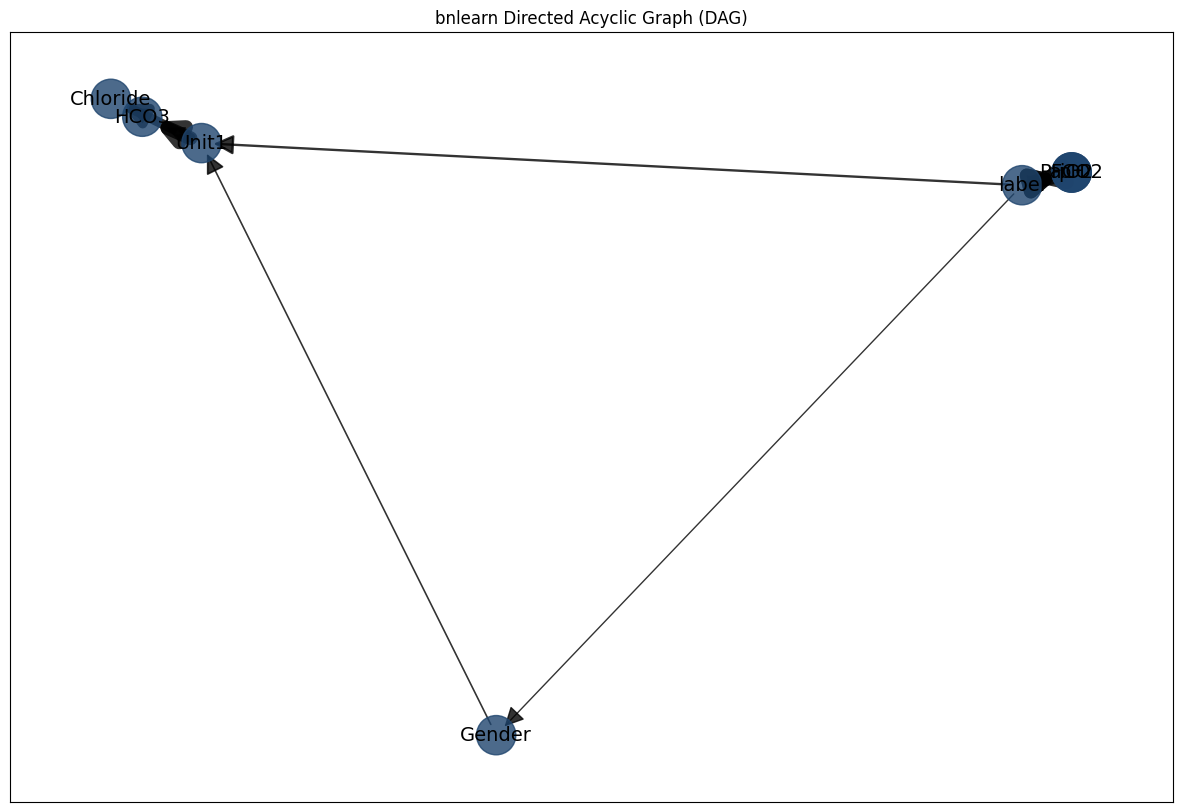

[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.


Exception: [bnlearn] >"d3blocks" library is not installed. Pip install first: "pip install d3blocks"

In [27]:
### Structure Learning ###

# Learn the structure
bn_model = bn.structure_learning.fit(train_df_discrete, methodtype='hc', scoretype='bic')
# Independence test
bn_model = bn.independence_test(bn_model, train_df_discrete, prune=True)
# Make plot
bn.plot(bn_model)
# Create interactive plot
bn.plot(bn_model, interactive=True)
